In [53]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from tensorflow.keras import applications

import tensorflow as tf
from tensorflow.keras.models import save_model

import tensorflow.keras.layers as L

import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import pandas as pd
import tqdm
import glob
import cv2
from skimage import io

print("done")

done


In [54]:
path ="101_ObjectCategories/Faces" 
#we shall store all the file names in this list 
filelist = [] 
for root, dirs, files in os.walk(path): 
    for file in files: 
        #append the file name to the list 
        filelist.append(os.path.join(root,file))

print(filelist)
print("Done")

['101_ObjectCategories/Faces\\image_0001.jpg', '101_ObjectCategories/Faces\\image_0002.jpg', '101_ObjectCategories/Faces\\image_0003.jpg', '101_ObjectCategories/Faces\\image_0004.jpg', '101_ObjectCategories/Faces\\image_0005.jpg', '101_ObjectCategories/Faces\\image_0006.jpg', '101_ObjectCategories/Faces\\image_0007.jpg', '101_ObjectCategories/Faces\\image_0008.jpg', '101_ObjectCategories/Faces\\image_0009.jpg', '101_ObjectCategories/Faces\\image_0010.jpg', '101_ObjectCategories/Faces\\image_0011.jpg', '101_ObjectCategories/Faces\\image_0012.jpg', '101_ObjectCategories/Faces\\image_0013.jpg', '101_ObjectCategories/Faces\\image_0014.jpg', '101_ObjectCategories/Faces\\image_0015.jpg', '101_ObjectCategories/Faces\\image_0016.jpg', '101_ObjectCategories/Faces\\image_0017.jpg', '101_ObjectCategories/Faces\\image_0018.jpg', '101_ObjectCategories/Faces\\image_0019.jpg', '101_ObjectCategories/Faces\\image_0020.jpg', '101_ObjectCategories/Faces\\image_0021.jpg', '101_ObjectCategories/Faces\\imag

In [55]:
def image2array(filelist):
    image_array = []
    for image in filelist[:400]:
        img = io.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        image_array.append(img)
    image_array = np.array(image_array)
    image_array = image_array.reshape(image_array.shape[0], 224, 224, 3)
    image_array = image_array.astype('float32')
    image_array /= 255
    return np.array(image_array)

train_data = image2array(filelist)

print("Length of training dataset:", train_data.shape)

Length of training dataset: (400, 224, 224, 3)


In [56]:
IMG_SHAPE = train_data.shape[1:]

def build_deep_autoencoder(img_shape, code_size):
    H,W,C = img_shape
    # encoder
    encoder = tf.keras.models.Sequential() # инициализация модели
    encoder.add(L.InputLayer(img_shape)) # добавление входного слоя, размер равен размеру изображения
    encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))

    # decoder
    decoder = tf.keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(14*14*256))
    decoder.add(L.Reshape((14, 14, 256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder


encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │       1,605,664 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,994,080 (7.61 MB)

 Trainable params: 1,994,080 (7.61 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 50176)               │       1,655,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_12                  │ (None, 28, 28, 128)         │         295,040 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_13                  │ (None, 56, 56, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_14                  │ (None, 112, 112, 32)        │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_15                  │ (None, 224, 224, 3)         │             867 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,043,971 (7.80 MB)

 Trainable params: 2,043,971 (7.80 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)
autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print("Done")

Done


In [75]:
autoencoder.fit(x=train_data, y=train_data, epochs=10, verbose=1)

images = train_data
codes = encoder.predict(images) 
assert len(codes) == len(images)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.0241
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.0235
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.0233
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.0237
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.0226
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.0231
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.0225
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.0216
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.0222
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.0216
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 380ms/step


In [76]:
from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"
    code = encoder.predict(image[None])    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    return distances,images[idx]
def show_similar(image):
    distances,neighbors = get_similar(image,n_neighbors=3)
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


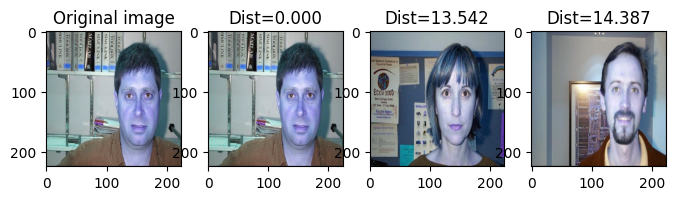

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


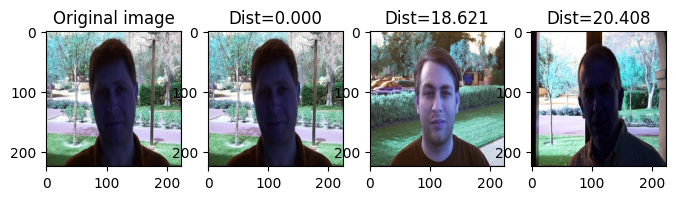

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


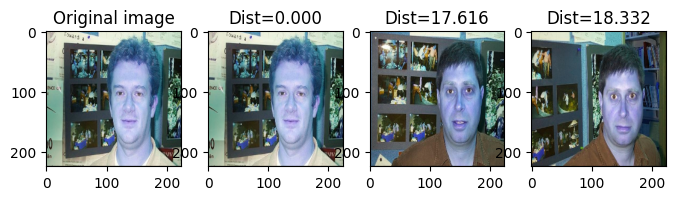

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


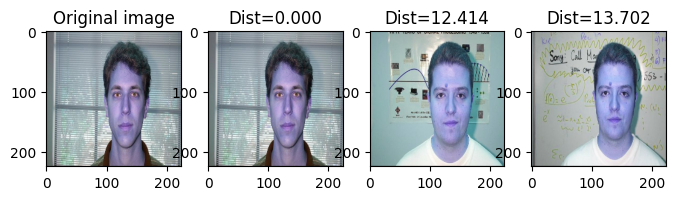

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


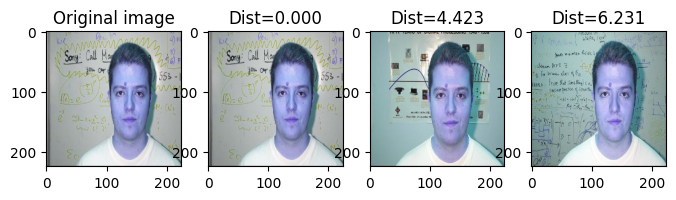

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


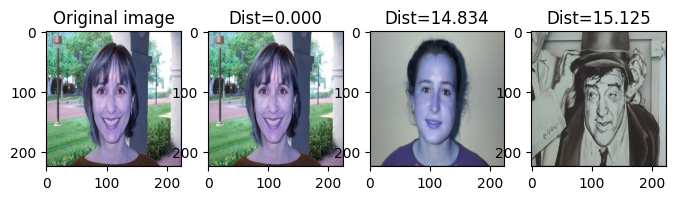

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


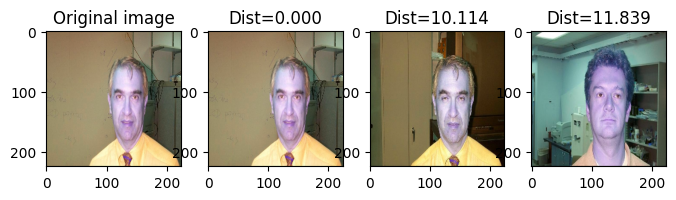

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


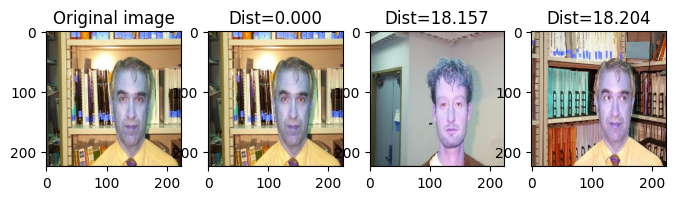

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


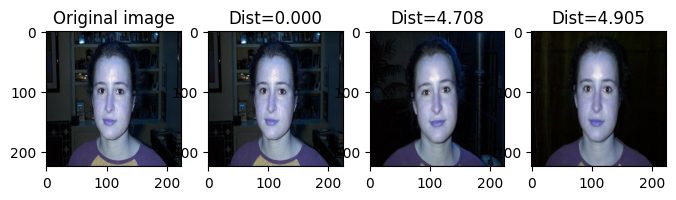

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


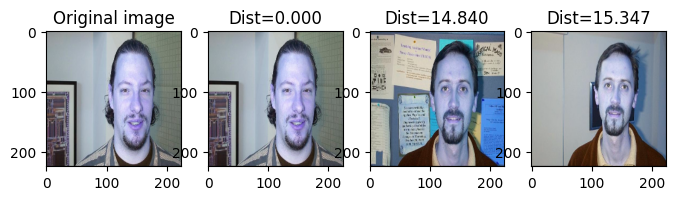

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


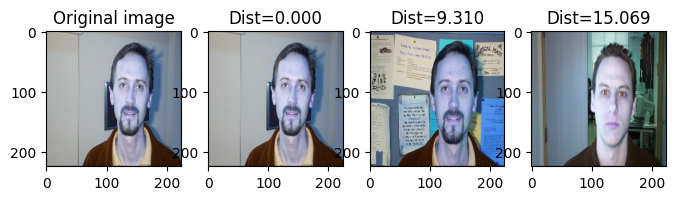

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


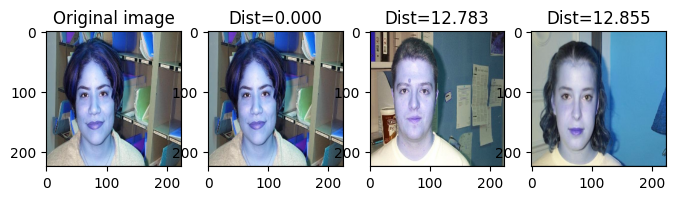

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


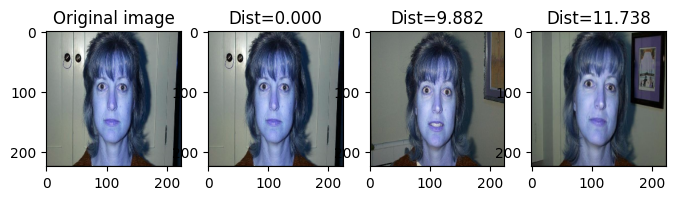

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


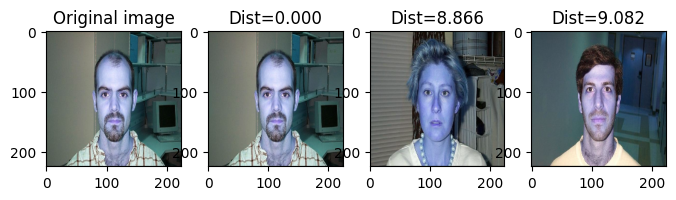

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


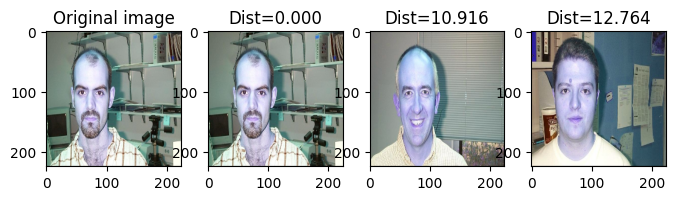

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


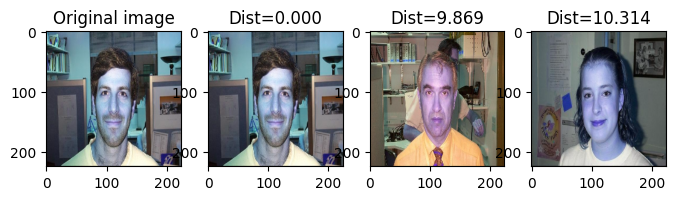

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


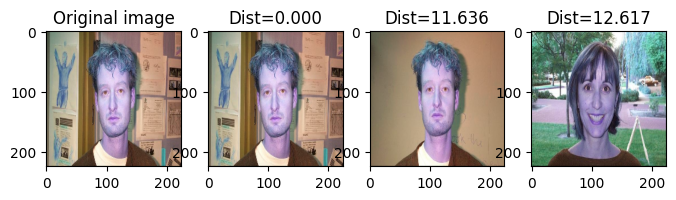

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


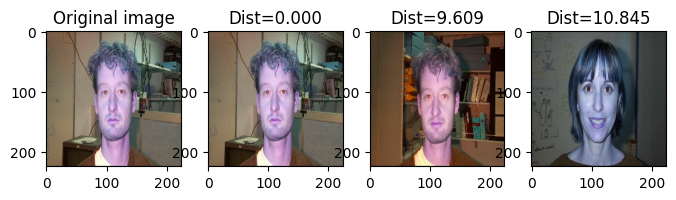

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


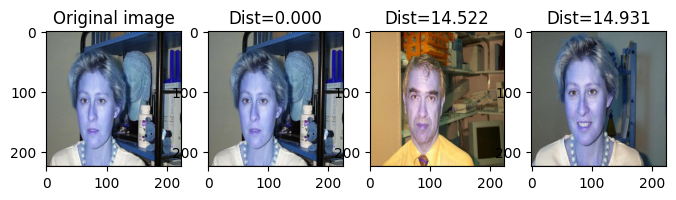

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


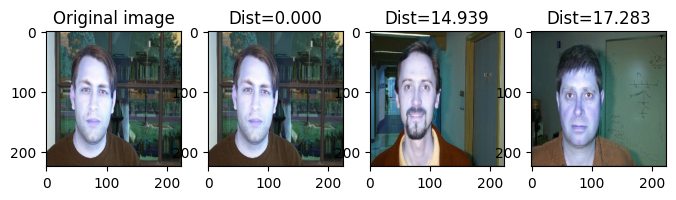

In [77]:
for i  in range(20):
    show_similar(train_data[i*15])